In [6]:
# Initialize Otter
import otter
grader = otter.Notebook("lab10.ipynb")

# Lab 10: Reinforcement Learning with Data
Welcome to the 10th DS102 lab! 

The goal of this lab is to explore solving MDPs by collecting data. This will include simple Monte Carlo estimates from offline data, and the online Q-learning algorithm. 

The code you need to write is indicated with `...`. There is additional documentation for each part as you go along.

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Submission
See the [Gradescope Submission Guidelines](https://edstem.org/us/courses/33922/discussion/2419862) for details on how to submit your lab.

**For full credit, this assignment should be completed and submitted before Wednesday, April 26th, 2023 at 11:59 PM PDT.**

## Collaborators
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [7]:
import copy
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Defining the GridWorld class 
We begin by defining a class for the environment in which we will run our experiments. This is the grid world from class where we can have both a stochastic or deterministic environment. In the stochastic case the agent will have a probability of 0.8 of going in the direction it's told to go, and a probability of 0.1 of going in each direction orthogonal to the direction it's meant to go in.

In [8]:
FORWARD_PROB = 0.8
LEFT_PROB = 0.1
RIGHT_PROB = 0.1
BACKWARD_PROB = 0.0
FIXED_PROB = 0.0
class GridWorld():
    """The grid world class.
    
    Inputs:
        grid : list of list of str
            The starting representation of the world. A single element
            must be "R" which represents the starting location of the robot.
            Any element that is "" represents a cell on which the robot can travel,
            "X" represents a rock which the robot can not travel on, and any
            cell with a string that can be converted to a number represents
            a terminal state with its corresponding reward.
        stochastic : bool
            Whether the environment is stochastic or deterministic.

    """
    def __init__(self, grid, stochastic):
        self._grid = grid
        self.num_rows = len(grid)
        self.num_cols = len(grid[0])
        self._stochastic = stochastic
        # Determine the starting location of the robot.
        for i in range(self.num_rows):
            for j in range(self.num_cols):
                if self._grid[i][j] == "R":
                    self._grid[i][j] = ""
                    self._row_pos = i
                    self._col_pos = j
                    self._start_row_pos = i
                    self._start_col_pos = j

    def reset(self):
        """Reset the environment to its original state."""
        self._row_pos = self._start_row_pos
        self._col_pos = self._start_col_pos
        return (self._row_pos, self._col_pos)
        
    def step(self, action):
        """Move the robot a single step in the world.
        
        Inputs:
            action : str
                The desired direction to travel in. Can either be
                "north", "west", "east", "south".
            
        Outputs:
            pos : tuple of int
                The location the robot ends up at after taking a step.
                The first element represents the row and the second element
                represents the column.
            reward : float
                The reward from taking this step.
            done : bool
                Whether the robot has reached a terminal state or not.

        """
        # Determine the transition probabilities based on the action and
        # whether the environment is stochastic or deterministic.
        if self._stochastic:
            if action == "north":
                transition_probs = {
                    "north": FORWARD_PROB,
                    "west": LEFT_PROB,
                    "east": RIGHT_PROB,
                    "south": BACKWARD_PROB,
                    "fixed": FIXED_PROB
                }
            if action == "west":
                transition_probs = {
                    "north": RIGHT_PROB,
                    "west": FORWARD_PROB,
                    "east": BACKWARD_PROB,
                    "south": LEFT_PROB,
                    "fixed": FIXED_PROB
                }
            if action == "east":
                transition_probs = {
                    "north": LEFT_PROB,
                    "west": BACKWARD_PROB,
                    "east": FORWARD_PROB,
                    "south": RIGHT_PROB,
                    "fixed": FIXED_PROB
                }
            if action == "south":
                transition_probs = {
                    "north": BACKWARD_PROB,
                    "west":RIGHT_PROB,
                    "east": LEFT_PROB,
                    "south": FORWARD_PROB,
                    "fixed": FIXED_PROB
                }
        else:
            transition_probs = {
                "north": 0.0,
                "west": 0.0,
                "east": 0.0,
                "south": 0.0,
                "fixed": 0.0
            }
            transition_probs[action] = 1.0
            
        # Account for the cases where we are on the boundaries or
        # next to a rock.
        row = self._row_pos
        col = self._col_pos
        if row == 0 or self._grid[row - 1][col] == "X":
            transition_probs["fixed"] += transition_probs["north"]
            transition_probs["north"] = 0.0
        if col == 0 or self._grid[row][col - 1] == "X":
            transition_probs["fixed"] += transition_probs["west"]
            transition_probs["west"] = 0.0
        if row == self.num_rows - 1 or self._grid[row + 1][col] == "X":
            transition_probs["fixed"] += transition_probs["south"]
            transition_probs["south"] = 0.0
        if col == self.num_cols - 1 or self._grid[row][col + 1] == "X":
            transition_probs["fixed"] += transition_probs["east"]
            transition_probs["east"] = 0.0

        # Decide which direction the robot will go.
        directions = list(transition_probs.keys())
        probs = list(transition_probs.values())
        move = np.random.choice(directions, p=probs)
        if move == "north":
            self._row_pos -= 1
        elif move == "west":
            self._col_pos -= 1
        elif move == "east":
            self._col_pos += 1
        elif move == "south":
            self._row_pos += 1

        # Check if we are on a final state and determine the reward.
        if self._grid[self._row_pos][self._col_pos] != "":
            reward = float(self._grid[self._row_pos][self._col_pos])
            done = True
        else:
            reward = 0.0
            done = False
            
        return (self._row_pos, self._col_pos), reward, done
            
    def render(self):
        """Print an ASCII visualization of the world."""
        for i, row in enumerate(self._grid):
            row_strs = []
            for j, elt in enumerate(row):
                sys.stdout.write(" -----")
                if i == self._row_pos and j == self._col_pos:
                    elt = "R"
                row_strs.append(elt.center(5))
            sys.stdout.write("\n")
            sys.stdout.write("|" + "|".join(row_strs) + "|")
            sys.stdout.write("\n")
        for _ in range(self.num_cols):
            sys.stdout.write(" -----")
        sys.stdout.flush()


Below we show you how to initialize and render a simple GridWorld environment:

In [9]:
# Here we initialize the environment.
simple_env = GridWorld([["R", "", "100",  "X", ],
                        ["", "X", "X", "X"],
                        ["", "", "",  "100"]], stochastic=False)

# Here we draw the initial state to the screen.
simple_env.render()

 ----- ----- ----- -----
|  R  |     | 100 |  X  |
 ----- ----- ----- -----
|     |  X  |  X  |  X  |
 ----- ----- ----- -----
|     |     |     | 100 |
 ----- ----- ----- -----

And how the robot moves in this environment:

In [10]:
# Here we take the "east" action and then draw the new state to the screen.
next_state, reward, is_done = simple_env.step("east")
simple_env.render()

 ----- ----- ----- -----
|     |  R  | 100 |  X  |
 ----- ----- ----- -----
|     |  X  |  X  |  X  |
 ----- ----- ----- -----
|     |     |     | 100 |
 ----- ----- ----- -----

In [11]:
# Here we print out the information that the "step" function returns.
print(next_state, reward, is_done)

(0, 1) 0.0 False


# Question 1: Monte Carlo Policy Evaluation

So far in class and in discussion section, we have considered the case where we have a **known** MDP and we want to solve for the value function. We've used the recursive Bellman equation to do so. For example, we can solve for the value of following a deterministic policy $\pi$ starting from a state $s$ by using the following defintion:

$$ V^{\pi}(s) = \mathbb{E}_{s'} \left[ R(s, \pi(s) ,s') + \gamma V^{\pi}(s') \right] = \sum_{s'} P(s' | s, \pi(s)) \left( R(s, \pi(s) ,s') + \gamma V^{\pi}(s') \right) $$

As long as we know $P$, $R$, and $\pi$', we can apply value iteration to compute $V^{\pi}(s)$.

In this question, we will begin to explore how to do Reinforcement Learning when we **don't know** $P$ or $R$. Instead we will collect data using a fixed policy $\pi$ and then estimate the value function directly. The simplest approach is called **Monte Carlo** policy evaluation. We collect many trajectories and then take a simple sample average. 

At first this might sound confusing. How do we compute a sample average for $V^{\pi}(s)$? The righthand side requires that we know $V^{\pi}(s)$! First, we need to introduce an equivalent but simpler way of writing the value function. It turns out that the value function is equivalent to the **average discounted sum of rewards** from running the policy $\pi$ starting in a state $s$. For an episode that lasts for $T$ time steps, we can write mathematically:

$$V^{\pi}(s) = \mathbb{E} \left[ \sum_{t=1}^T \gamma^{t-1} R(s_t, a_t, s'_t)  \right]$$

where $s_1 = s$, $a_t \sim \pi(s_t)$, and $s'_t \sim P(\cdot | s_t, a_t)$. Note that the expectation is taken with respect to both the randomness in $\pi$ (if any) and the randomness in $P$.

Solving this expectation mathematically using $P$, $R$, and $\pi$ is very difficult - that's why we typically use the Bellman equation instead. But if we collect many trajectories from running $\pi$ in the environment, then this equation is much simpler: we just take the sample average.

For a concrete example, let's consider the simple uniform random policy. This policy ignores the state and chooses between the four actions uniformly at random.

In [12]:
def random_policy(s):
    """Return a random action."""
    a = np.random.choice(["north", "south", "east", "west"])
    return a

## Question 1a

Now you will write some code which takes a policy (in the form of a function from states to actions just like the code above) and then runs that policy in a given GridWorld environment so that we can collect a dataset.

In [13]:
def run_policy(pi, env, render=False):
    
    """Run an agent that follows a fixed policy
    
    Inputs:
        pi : function
            A function that takes a state and returns an action
        env : GridWorld
            The environment in which to run the agent.
        render : bool
            Whether to print the environment as it goes through each iteration.
    
    Returns:
        samples: list of tuple of float
            A list of (state, action, next state, reward) tuples from running
                the policy in the environment
    """
    
    state = env.reset()
    if render:
        time.sleep(1.0)
        clear_output(wait=True)
        env.render()
        
    done = False
    samples = []
    while not done:
        old_state = state
        
        # use the policy to get the next action
        action = pi(state)
        
        # apply the action in the environment
        state, reward, done = env.step(action)
        
        samples.append((old_state, action, state, reward))
        if render:
            time.sleep(0.3)
            clear_output(wait=True)
            env.render()
            
    return samples

In [14]:
grader.check("q1a")

q1a results: All test cases passed!

Lets watch the random policy in action:

In [15]:
np.random.seed(20)
samples = run_policy(random_policy, simple_env, True)

 ----- ----- ----- -----
|     |     | 100 |  X  |
 ----- ----- ----- -----
|     |  X  |  X  |  X  |
 ----- ----- ----- -----
|     |     |     |  R  |
 ----- ----- ----- -----

## Question 1b

We just collected a dataset called `samples` which is a list of (state, action, next state, reward) tuples. For time step $t$, denote the collected tuple $(s_t, a_t, s'_t, r_t)$. We can now compute the discounted sum of rewards:

$$\sum_{t=1}^T \gamma^{t-1} R(s_t, a_t, s'_t) $$

Remember: this is what was inside the expectation in our new way of writing the value function! This sum is sometimes called the **return** of an episode. In the textbox below, given a list of $(s,a,s',r)$ tuples, you will calculate the discounted sum of rewards.

In [16]:
def calculate_return(samples, gamma=0.9):
    """Compute the discounted sum of rewards given a trajectory of samples.
    
    Inputs:
        samples : list of tuple of float
            A list of (state, action, next state, reward) tuples from running
                the policy in the environment.
        gamma : float
            The discount factor.
    
    Returns:
        value: float
            The discounted sum of rewards from the samples list.
    """
    value = 0
    for i in np.arange(len(samples)):
        value += ((gamma ** i) * samples[i][3])
    return value


In [17]:
grader.check("q1b")

q1b results: All test cases passed!

The value function for the starting state is the **average** discounted sum of rewards given the randomness in the environment and the policy. Finally, we'll compute our Monte Carlo estimate. We collect several trajectories, calculate the return for each trajectory, and then take the sample average:

In [18]:
returns = []
np.random.seed(20)
for _ in range(100):
    samples = run_policy(random_policy, simple_env, False)
    returns.append(calculate_return(samples))
value = np.array(returns).mean()

print(value)

34.862835831001924


Monte Carlo policy evaluation gives us an estimate of the value of a single policy starting from a single state.  Your estimate above should be around $35$. 

<!-- BEGIN QUESTION -->

## Question 1c

Before we move on, summarize in your own words what steps we take to compute a Monte Carlo estimate of the value function for a policy $\pi$.

To compute the Monte Carlo estimate of the value function for a policy, we collect several trajectories and calculate the discounted return for each trajectory. We then take the sample average and use that as our Monte Carlo estimate.

<!-- END QUESTION -->

The random policy spends a lot of time meandering so on average the value is much smaller than 100. By looking at the grid world diagram, you can see we could do better if the robot just moved to the right twice in a row and immediately reached the terminal state.

Instead of evaluating a fixed policy, we can also use data to solve for the **optimal** policy. In the next section, we'll show you how to estimate the optimal policy using the Q-learning algorithm.

# Question 2: Setting up Q-Learning 

Next, we will implement Q-learning for the grid world environment defined above. Recall that the optimal Q-function at a given state $s$ for an action $a$ is defined as
$$Q(s, a) = \sum_{s'} P(s'| a, s)\left[R(s, a, s') + \gamma \max_{a'} Q(s', a')\right]$$
where $\gamma$ is the discount factor, $P(s'| s,a)$ is the state transition probability function, and $R(s, a, s')$ is the reward function.

**Note:** we can also define the $Q$-function as an average discounted sum like we did in Question 1. But for Q-learning, it's more convenient to use the recursive definition. This is a common trick in RL. You switch back and forth between the recursive and discounted sum definitions depending on what makes your problem easier.

## Question 2a: Getting the optimal policy from the optimal Q-function.

We know that the optimal policy chooses the action which maximizes the optimal Q-function at a given state:

$$\pi^*(s) = \text{argmax}_a Q(s, a)$$

Fill in the following code which takes a state and a Q-function and then returns a list of the maximizing actions. **If there is more than one action with the highest Q-value estimate, include them all in the list.**

In [19]:
def greedy_action(state, Q_values):
    """Given a state and a Q-function, return the actions which maximizes the Q-function.
    
    Inputs:
        state : int
        Q_values : dict of dict
            A Q function. The first index is over states
            while the second index is over actions. So for example
            Q_values[(1, 2)]["north"] is the Q-value for the state at position
            (1, 2) and with action "north".
            
    Returns:
        best_actions : list of string
            The actions which maximizes the Q-function at the given state. 
    """
    
    best_actions = []
    best_value = -float("inf")
    for action, value in Q_values[state].items():
        if value > best_value:
            best_actions, best_value = [action], value
        elif value == best_value:
            best_actions.append(action)
    return best_actions

In [20]:
grader.check("q2a")

q2a results: All test cases passed!

In the cell below, we provide you with a simple GridWorld and it's optimal Q-function so that you can test your code.

In [21]:
env = GridWorld([["R", "100"],
                 ["", "100"],
                 ["100", "X"]], stochastic=False)
env.render()

Qopt = { (0, 0): {'north': 90, 'west': 90,'east': 100,'south': 90},
         (0, 1): {'north': 0, 'west': 0, 'east': 0,'south': 0},
         (1, 0): {'north': 90, 'west': 90, 'east': 100,'south': 100},
         (1, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
         (2, 0): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
         (2, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0} }

 ----- -----
|  R  | 100 |
 ----- -----
|     | 100 |
 ----- -----
| 100 |  X  |
 ----- -----

## Question 2b:  Learning the Q-function 

Using the code above, if we knew the optimal Q-function, then we could find the optimal policy. If we knew $P$ and $R$, then we could compute the optimal Q-function using Q iteration. But what if we don't know $P$ and $R$? There is a very clever algorithm called **Q-learning** which can solve for $Q(s,a)$ by collecting data. For Monte Carlo estimation, we needed to collect a bunch of trajectories all at once using a single policy. Q-learning is an online algorithm which **adapts** the data-collection policy after every action, getting closer and closer to the optimal policy.  

After every step, we update our estimate of the optimal Q-function using the new state and reward we observe. For example, say we have some estimate of the Q-function $\hat{Q}_k$ after observing $k$ samples, and say we observe a new sample which consists of $s$ the state we were at, $a$ the action we performed, $s'$ the state we ended up at, and $r$ the reward we got. Then our updated $Q$ function is given by
$$\hat{Q}_{k + 1}(s, a) \leftarrow (1 - \alpha)\hat{Q}_k(s, a) + \alpha \left[r + \gamma\max_{a'} \hat{Q}_k(s', a')\right]$$
where $\alpha$ is a parameter between $0$ and $1$ that we set.

### Fill in the function below, which updates the Q function using observed samples. 

In [37]:
def update_Q(Q_values, old_state, action, new_state, reward, gamma, alpha):
    """Given an old estimate of the Q function (given by the Q_values dict),
    compute a new estimate by using observed samples.
    
    Modifies the Q_values dict in place, and does not return anything.
    
    Inputs:
        Q_values : dict of dict
            The estimate of the optimal Q values. The first index is over states
            while the second index is over actions. So for example
            Q_values[(1, 2)]["north"] is the Q-value for the state at position
            (1, 2) and with action "north".
        old_state : tuple of int
            The state we were previously at before making the given action. The
            first index represents the row while the second index represents the
            column of the state.
        action : string
            The action we made. Can either be "north", "east", "west" or "south".
        new_state : tuple of int
            The state we transitioned to after making the given action.
        reward : float
            The reward we obtained after making our action.
        gamma : float
            The discount factor for the Q-function.
        alpha : float
            The proportion that tells us how we will weigh new incoming estimates of Q.
    """
    # First compute the maximum Q-value at the new state.
    max_Q = max(Q_values[new_state].values())

    # Now update the new Q value estimates in place.
    Q_values[old_state][action] = ((gamma * max_Q) + reward) * alpha + Q_values[old_state][action] * (1 - alpha)
    return Q_values

In [38]:
grader.check("q2b")

q2b results: All test cases passed!

Below is another cell for testing your code:

In [39]:
env = GridWorld([["R", "100"],
                 ["", "100"],
                 ["100", "X"]], stochastic=False)
env.render()

Q_current = { (0, 0): {'north': 10, 'west': 15,'east': 20,'south': 10},
              (0, 1): {'north': 0, 'west': 0, 'east': 0,'south': 0},
              (1, 0): {'north': 20, 'west': 15, 'east': 10,'south': 20},
              (1, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
              (2, 0): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
              (2, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0} }

old_state = (0,0)
action = 'east'
new_state = (0,1)
reward = 100

update_Q(copy.deepcopy(Q_current), old_state, action, new_state, reward, 0.75, 0.15)

 ----- -----
|  R  | 100 |
 ----- -----
|     | 100 |
 ----- -----
| 100 |  X  |
 ----- -----

{(0, 0): {'north': 10, 'west': 15, 'east': 32.0, 'south': 10},
 (0, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
 (1, 0): {'north': 20, 'west': 15, 'east': 10, 'south': 20},
 (1, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
 (2, 0): {'north': 0, 'west': 0, 'east': 0, 'south': 0},
 (2, 1): {'north': 0, 'west': 0, 'east': 0, 'south': 0}}

## Question 2c: Q-Learning Agent

Now that we've implemented our Q-fuction update, we will define a agent that runs Q-learning in the environment. The agent will use two different exploration policies:

1. greedy policy: The first type of agent always picks an action that maximizes our current estimate of the Q-function.
2. $\epsilon$-greedy policy: The second type picks the best estimate of the Q-function with probability $1-\epsilon$, and picks a random action uniformly from the action space with probability $\epsilon$. 

The first type is called a greedy agent while the second type is called an $\epsilon$-greedy agent. Remember that taking greedy actions according to the **optimal** Q-function always results in the optimal policy. But when we are still learning the Q-function, we will see why $\epsilon$-greedy agents are sometimes useful. 

First we define some useful helper functions:

In [40]:
def init_Q(env):
    """Return initial Q-value estimates with all values 0."""
    Q_values = {}
    for i in range(env.num_rows):
        for j in range(env.num_cols):
            Q_values[i, j] = {
                "north": 0.0,
                "west": 0.0,
                "east": 0.0,
                "south": 0.0
            }
    return Q_values

def visualize_value(Q, env):
    for i, row in enumerate(env._grid):
        row_strs = []
        for j, elt in enumerate(row):
            sys.stdout.write(" -------")
            
            action = greedy_action((i,j), Q)[0]
            elt = "{:.3f}".format(Q[(i,j)][action]) 
            
            row_strs.append(elt.center(7))
        sys.stdout.write("\n")
        sys.stdout.write("|" + "|".join(row_strs) + "|")
        sys.stdout.write("\n")
    for _ in range(env.num_cols):
        sys.stdout.write(" -------")
    sys.stdout.flush()

### Fill in the `run_agent` function below that runs both of these types of agents.

Note: Because of the randomness inherent in the function, you will have to search through the actions in the order "north", "west", "east", "south" when 
looking for which arms have the maximum value and you will have to use `np.random.choice` to choose.

**Hint:** you already wrote code that returns a list of actions that maximize the Q-function.

In [41]:
# TODO: fill in the best actions for the agent in the run_agent function.
# The run_agent function can run either the greedy agent or the epsilon-greedy agent, 
# depending on the parameter epsilon that gets passed in.
    
def run_agent(Q_values, env, num_rollouts, gamma=0.9, alpha=0.1, epsilon=0.0, render=False, show_train=False):
    """Run a Q-learning agent in a given environment.
    
    Inputs:
        Q_values : dict of dict
            The Q value estimates to start from.
        env : GridWorld
            The environment in which to run the agent.
        num_rollouts : int
            The number of times we wish to reset the environment
            to its original state.
        gamma : float
            The discount factor for the Q-function.
        alpha : float
            The proportion that tells us how we will weigh new incoming estimates of Q.
        epsilon : float
            The proportion of times the agent will randomly pick an action instead
            of making the optimal move in terms of the current estimate Q-function.
            If epsilon is set to 0 this corresponds to a greedy agent.
        render : bool
            Whether to print the environment as it goes through each iteration.
        show_train: bool
            If render is True, then show_train will also visualize the estimated value function
    
    Returns:
        Q_values : dict of dict
            The learned Q values. The first index is over states
            while the second index is over actions. So for example
            Q_values[(1, 2)]["north"] is the Q-value for the state at position
            (1, 2) and with action "north".
    """
    for i in range(num_rollouts):
        state = env.reset()
        if render:
            time.sleep(1.0)
            clear_output(wait=True)
            env.render()
            print()
            if show_train:
                visualize_value(Q_values, env)
        done = False
        samples = []
        while not done:
            if np.random.binomial(1, epsilon):
                action = random_policy(state) # take random action
            else:
                # Take the best action according to the Q-value estimate.
                # If multiple values are equal, randomly chose between them.
                best_actions = greedy_action(state, Q_values)
                action = np.random.choice(best_actions)
            old_state = state
            state, reward, done = env.step(action) # update state
            samples.append((old_state, action, state, reward))
            if render:
                time.sleep(0.3)
                clear_output(wait=True)
                env.render()
                print()
                if show_train:
                    visualize_value(Q_values, env)
        # Update the Q-function using samples from this rollout.
        for old_state, action, state, reward in reversed(samples):
            Q_values = update_Q(Q_values, old_state, action, state, reward, gamma, alpha)
    return Q_values

In [42]:
grader.check("q2c")

q2c results: All test cases passed!

## Question 3. Q-learning in a deterministic setting 
Let's compare the behavior of the greedy agent vs. the $\epsilon$-greedy agent. We consider a two-path setting where the agent can either receive a small reward by following a short path or a large reward by following a long path. In this setting, for any set of actions, the reward is deterministic.

In the printed Grid World, R represents the agent, X's represent obstacles, and numbers represent rewards for reaching those positions.

In [43]:
# Initialize the world.
env = GridWorld([["",  "", "", "", "", "100",  "X", ],
                 ["",  "X", "X", "X", "X", "X", "X"],
                 ["",  "", "", "", "R", "",  "1"]], stochastic=False)

### First, we'll watch the first 5 training iterations with actions the agent:

Visualized underneath the grid is the current estimate of the value function (i.e. the estimated Q function after choosing the maximizing action in each state). 

In [44]:
np.random.seed(4)
Q_values = init_Q(env)
Q_values = run_agent(Q_values, env, 5, alpha=0.5, render=True, show_train=True)

 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     | 100 |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |  X  |  X  |  X  |  X  |  X  |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |  R  |
 ----- ----- ----- ----- ----- ----- -----
 ------- ------- ------- ------- ------- ------- -------
| 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------
| 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------
| 0.000 | 0.000 | 0.000 | 0.101 | 0.731 | 0.938 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------

### Now we'll run training for 100 rollouts and then observe the behavior of the agent under the resulting Q estimate:

In [45]:
# No coding TODOs here, just run this cell to observe what the greedy agent does.
np.random.seed(0)

# Initialize the Q-value estimates.
Q_values = init_Q(env)

# TRAIN: Learn the Q-value for 100 rollouts.
Q_values = run_agent(Q_values, env, 100, alpha=0.5, render=False)

# Now let's see what the agent plays after learning the Q-values.
Q_values = run_agent(Q_values, env, 1, render=True)

 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     | 100 |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |  X  |  X  |  X  |  X  |  X  |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |  R  |
 ----- ----- ----- ----- ----- ----- -----


In [46]:
visualize_value(Q_values, env)

 ------- ------- ------- ------- ------- ------- -------
| 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------
| 0.009 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------
| 0.021 | 0.081 | 0.128 | 0.152 | 0.900 | 1.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------

<!-- BEGIN QUESTION -->

## Question 3a: 

Which reward did the agent go for? Why do you think this happened? 

The agent went for the reward of value 1. This is because it is the greedy algorithm that will rather receive a small reward with a short path.

<!-- END QUESTION -->

### Now let's try to run a simple $\epsilon$-greedy agent in this setting.

Let's try setting $\epsilon$ to 0.3 in this case.

In [47]:
# No coding TODOs here, just run this cell to observe what the epsilon-greedy agent does.
np.random.seed(0)

# Initialize the Q-value estimates.
Q_values = init_Q(env)

# Learn the Q-value for 100 rollouts.
Q_values = run_agent(Q_values, env, 100, epsilon=0.3, alpha=1.0, render=False)
# Now let's see what the agent plays after learning the Q-values.
Q_values = run_agent(Q_values, env, 1, render=True)

 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |  R  |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |  X  |  X  |  X  |  X  |  X  |  X  |
 ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |  1  |
 ----- ----- ----- ----- ----- ----- -----


In [48]:
visualize_value(Q_values, env)

 ------- ------- ------- ------- ------- ------- -------
| 65.610| 72.900| 81.000| 90.000|100.000| 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------
| 59.049| 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- -------
| 53.144| 47.830| 43.047| 38.742| 34.868| 31.381| 0.000 |
 ------- ------- ------- ------- ------- ------- -------

<!-- BEGIN QUESTION -->

### Question 3b: 

What did the $\epsilon$-greedy agent do? If it was different from the greedy agent, why do you think this happened?

The E-greedy agent went for the reward of value 100. This happened becasue the algorithm was willing to walk a longer path to discover higher-valued rewards.

<!-- END QUESTION -->

## Question 4. Q-learning in a stochastic setting
Finally, let's consider the stochastic setting. In stochastic Grid World, the agent moves in its chosen direction with probability 0.8, and moves in each direction orthogonal to the direction it had meant to go in with probability 0.1. We'll consider a setting where we have a bridge that leads to a high-value end-state. However, crossing carries with it a **risk** of falling down the side of the bridge.

For this simulation, we will just look at an $\epsilon$-greedy agent with $\epsilon = 0.3$. This time, we will observe the effects of changing the the discount factor $\gamma$ for the Q-function.

### In the cell below, test some different values of $\gamma$ and try to find a value of $\gamma$ that will lead the agent to try to cross the bridge and a value of $\gamma$ that will lead the agent to take the lower valued option.

There aren't any special characters to mark the bridge here, the bridge is just represented by the two blank squares with -100's on either side. The agent has a small chance of falling into a squares with -100 reward when passing through each of these "bridge" squares. 

In [68]:
# TODO: run this cell with different values of gamma.
np.random.seed(0)

# Initialize the world.
env = GridWorld([["",  "", "", "", "", "", "",  "-100", "-100", ""],
                 ["1", "", "", "", "", "R", "","", "","200"],
                 ["",  "", "", "", "", "", "",  "-100", "-100", ""]], stochastic=True)

# Initialize the Q-value estimates.
Q_values = init_Q(env)

# Learn the Q-value for 1000 rollouts.
# Try different values of gamma from 0.1 to 0.9
Q_values = run_agent(Q_values, env, 1000, epsilon=0.3, gamma=0.9, alpha=0.1, render=False)

# Now let's see what the agent plays after learning the Q-values.
Q_values = run_agent(Q_values, env, 1, render=True)

 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |     | -100| -100|     |
 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
|  1  |     |     |     |     |     |     |     |     |  R  |
 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----
|     |     |     |     |     |     |     | -100| -100|     |
 ----- ----- ----- ----- ----- ----- ----- ----- ----- -----


In [65]:
visualize_value(Q_values, env)

 ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
| 0.887 | 0.133 | 0.017 | 0.002 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
| 0.000 | 0.861 | 0.067 | 0.005 | 0.000 | 0.000 | 0.000 | -7.542| 57.602| 0.000 |
 ------- ------- ------- ------- ------- ------- ------- ------- ------- -------
| 0.812 | 0.072 | 0.006 | 0.001 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
 ------- ------- ------- ------- ------- ------- ------- ------- ------- -------

<!-- BEGIN QUESTION -->

## Question 4a

What values of gamma did you use to achieve each behavior? Why did these values work?

Gamma (cross bridge) = 0.9
Gamma (lower valued) = 0.1
A higher discount rate means that the algorithm does not mind finding a reward further steps away, while a lower discount rate signifies that the algorithm views further rewards as less valuable. The smaller the discount rate, the more unworthy it is for the algorithm to search for farther results. When G = 0.9, the algorithm can search for rewards further away without taking away too much value. However, at G = 0.1, it is simply not worth it to search for farther away rewards, so the algorithm will take the lower valued option.

<!-- END QUESTION -->



Yay, you've made it to the end of Lab 10!


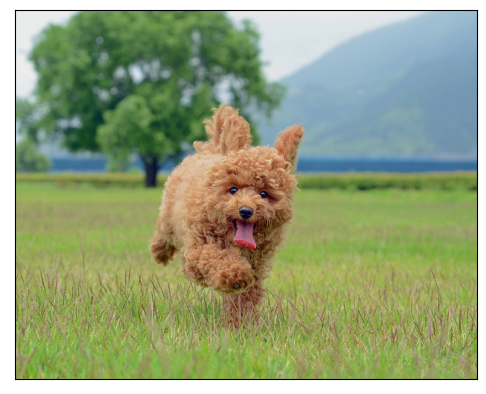

In [69]:
import matplotlib.image as mpimg
img = mpimg.imread('qt.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 10!")
plt.show()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)